# Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

# Data Downloading and Feature-Target Separation

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)


train_features = train_dataset.data.unsqueeze(1).float() / 255.0
train_targets = train_dataset.targets

test_features = test_dataset.data.unsqueeze(1).float() / 255.0
test_targets = test_dataset.targets

train_features = (train_features - 0.5) / 0.5
test_features = (test_features - 0.5) / 0.5

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.58MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.03MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# FGSM Attack

In Fast Gradient Sign Method (FGSM) adversarial attack, we will calculate the gradient of the loss with respect to the input image and use this to add perturbation to the image in the direction of the gradient sign. The perturbation size is controlled by eps, and the adversarial images are made to stay within valid pixel range.

In [3]:
#  FGSM attack function
def fgsm_attack(model, images, labels, eps=0.3):
    model.eval()
    images = images.to(device)
    labels = labels.to(device)
    images.requires_grad = True

    # Forward pass
    outputs = model(images)
    loss = nn.CrossEntropyLoss()(outputs, labels)

    # Backward pass
    model.zero_grad()
    loss.backward()

    # adversarial examples
    adv_images = images + eps * images.grad.sign()
    adv_images = torch.clamp(adv_images, min=0, max=1).detach()
    return adv_images

# CNN model

In [4]:
# Simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)  # Output: 28x28x32
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 14x14x32

        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)  # Output: 14x14x64
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 7x7x64

        self.fc1 = nn.Linear(7 * 7 * 64, 1024)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 7 * 7 * 64)  # Flatten
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Clubbing perturbed and clean features

In [7]:
# Generating a new dataset with FGSM attack
def generate_fgsm_dataset(model, features, targets, eps=0.3):
    original_features = features.clone()
    targets = targets.clone()

    perturbed_features = []
    batch_size = 128
    model.eval()

    for i in range(0, len(features), batch_size):
        batch_features = features[i:i + batch_size].to(device)
        batch_targets = targets[i:i + batch_size].to(device)
        perturbed_batch = fgsm_attack(model, batch_features, batch_targets, eps)
        perturbed_features.append(perturbed_batch.cpu())

    perturbed_features = torch.cat(perturbed_features, dim=0)

    combined_features = torch.cat([original_features, perturbed_features], dim=0)
    combined_targets = torch.cat([targets, targets], dim=0)

    return TensorDataset(combined_features, combined_targets)


In [8]:
new_train_dataset = generate_fgsm_dataset(model, train_features, train_targets, eps=0.3)
new_test_dataset = generate_fgsm_dataset(model, test_features, test_targets, eps=0.3)

new_train_loader = DataLoader(new_train_dataset, batch_size=64, shuffle=True)
new_test_loader = DataLoader(new_test_dataset, batch_size=64, shuffle=False)

# Training the CNN Model on New Dataset

In [9]:
# training function
def train_model(model, train_loader, epochs=5):
    model.train()
    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(epochs):
        epoch_loss = 0
        correct = 0
        total = 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, predicted = outputs.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

        # Calculating average loss and accuracy
        avg_loss = epoch_loss / len(train_loader)
        accuracy = 100. * correct / total

        # Storing loss and accuracy for plotting
        epoch_losses.append(avg_loss)
        epoch_accuracies.append(accuracy)

        print(f"Epoch {epoch + 1}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.2f}%")


    return epoch_losses, epoch_accuracies

In [10]:
train_model(model, new_train_loader, epochs=5)

Epoch 1: Loss = 0.0958, Accuracy = 97.02%
Epoch 2: Loss = 0.0289, Accuracy = 99.11%
Epoch 3: Loss = 0.0186, Accuracy = 99.43%
Epoch 4: Loss = 0.0133, Accuracy = 99.58%
Epoch 5: Loss = 0.0120, Accuracy = 99.65%


([0.09579837020007738,
  0.028925057118506327,
  0.01858394233909057,
  0.013303606917018079,
  0.012012282686940913],
 [97.01833333333333, 99.105, 99.43416666666667, 99.58333333333333, 99.65])

# Evaluation

In [11]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = outputs.max(1)
            correct += predicted.eq(target).sum().item()
            total += target.size(0)

    print(f"Test Accuracy: {100. * correct / total:.2f}%")

evaluate_model(model, new_test_loader)

Test Accuracy: 98.99%


In [13]:
from PIL import Image
import torch
import torchvision.transforms as transforms

image_path = '/content/5.png'
image = Image.open(image_path).convert('L')

#Preprocessing image
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
image_tensor = transform(image).unsqueeze(0)

image_tensor = image_tensor.to(device)


model.eval()
with torch.no_grad():
    output = model(image_tensor)
    _, predicted_label = output.max(1)

print(f'Predicted Label: {predicted_label.item()}')


Predicted Label: 5


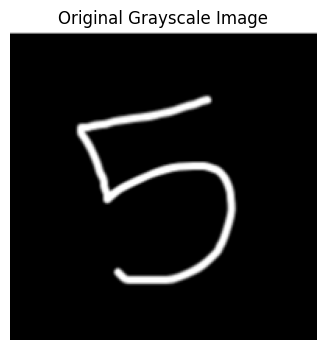

Predicted Label: 5


In [15]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Load and preprocess the image
image_path = '/content/5.png'
image = Image.open(image_path).convert('L')

transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize to 28x28
    transforms.ToTensor(),        # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to range [-1, 1]
])

# Apply transformations
image_tensor = transform(image).unsqueeze(0)

# Visualize the image before normalization
plt.figure(figsize=(4, 4))
plt.imshow(image, cmap="gray")
plt.title("Original Grayscale Image")
plt.axis("off")
plt.show()

image_tensor = image_tensor.to(device)

# Predict using the model
model.eval()
with torch.no_grad():
    output = model(image_tensor)
    _, predicted_label = output.max(1)

print(f'Predicted Label: {predicted_label.item()}')

